<a href="https://colab.research.google.com/github/IamAtreus/00-Tensorflow/blob/PyTorch/01_PyTorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import torch
from torch import nn
import torchvision as tv 
import torchaudio as ta 
import matplotlib.pyplot as plt

print(torch.__version__)

1.12.1+cu113


## 1. Data (preparing and loading)
* Speadssheet
* images
* video
* audio
* text
* Even DNA

Can be converted to numbers, it can be used.

# starting with Y=a+bx


In [2]:
weight = 0.7 # a
bias = 0.3 # b

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # X in ml is always uppercase
y = weight * X + bias

X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)


(50, 50)

## *Splitting data into training and test sets*

In [4]:
# Creating data spilt for training and test

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="training data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="test data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="predictions")
  
  plt.legend(prop={"size": 14})

  

  



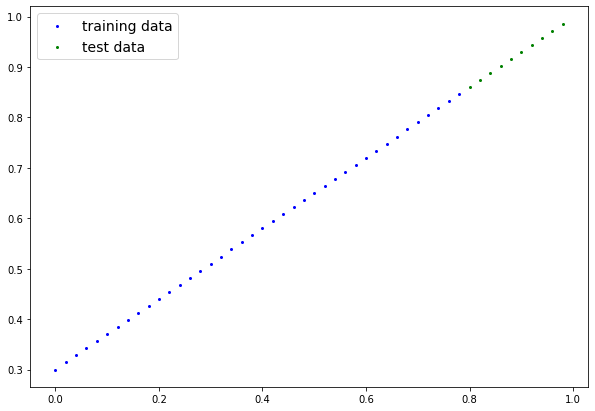

In [6]:
plot_predictions();

## Building a model

In [7]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                           requires_grad=True,
                                           dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # y=a+bx



### PyTorch model building essentials

* torch.nn - contains all of the buildings for cpu graph
* torch.nn.Parameter - what parameter model try and learn
* torch.nn.Moduel - the base class for nn 
* torch.optim - optimizers
* def forward() - base moduels for all nn.Modules


In [8]:
# create a random seed

torch.manual_seed(42)

# create a instance

model_0 = LinearRegressionModel()

# check the prem

list(model_0.parameters())



[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Predictions on model

In [10]:
# using torch.interence_mode()

with torch.inference_mode(): # context manager
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

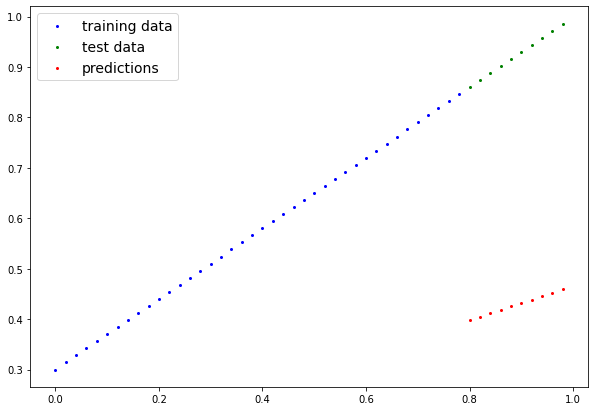

In [11]:
plot_predictions(predictions=y_preds)

### Training the model intuition

In [12]:
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
# setup loss function. For images nn.BCELoss can be used with better results

loss_fn = nn.L1Loss()

# setup an optimizer
# algo: stochastic gradient decent.
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001)





### building a trainingloop and a training loop in PyTorch

0. Loop the data
1. forward propagation
2. Calc the loss, compagre forward predicition to ground truth.
3. optimizer zero grad
4. Loss backward trhrough the network. ( **backpropagation** )
5. Optimizer step. ( **gradient decent** )

In [21]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 50 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.02435956709086895 | MAE Test Loss: 0.05690721794962883 
Epoch: 50 | MAE Train Loss: 0.022642139345407486 | MAE Test Loss: 0.05283904820680618 
Epoch: 100 | MAE Train Loss: 0.02092517353594303 | MAE Test Loss: 0.0488395169377327 
Epoch: 150 | MAE Train Loss: 0.019208211451768875 | MAE Test Loss: 0.04483998939394951 
Epoch: 200 | MAE Train Loss: 0.017490629106760025 | MAE Test Loss: 0.04084048420190811 
Epoch: 250 | MAE Train Loss: 0.015772998332977295 | MAE Test Loss: 0.036772288382053375 
Epoch: 300 | MAE Train Loss: 0.014056024141609669 | MAE Test Loss: 0.03277278691530228 
Epoch: 350 | MAE Train Loss: 0.012339059263467789 | MAE Test Loss: 0.028773266822099686 
Epoch: 400 | MAE Train Loss: 0.010621682740747929 | MAE Test Loss: 0.0247737355530262 
Epoch: 450 | MAE Train Loss: 0.008904037065804005 | MAE Test Loss: 0.020774226635694504 
Epoch: 500 | MAE Train Loss: 0.007186878472566605 | MAE Test Loss: 0.01670604944229126 
Epoch: 550 | MAE Train Loss: 0.00546

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5788])), ('bias', tensor([0.3509]))])

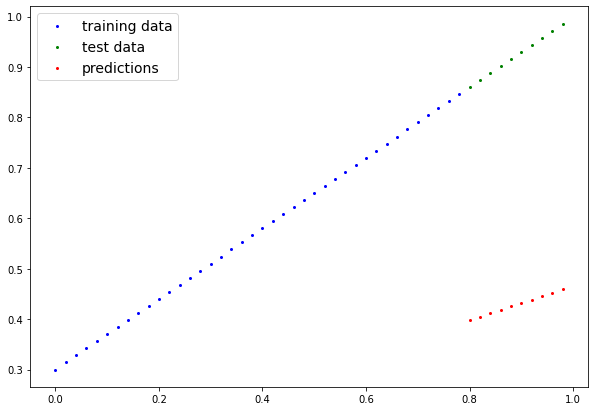

In [24]:
plot_predictions(predictions=y_preds);

In [22]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

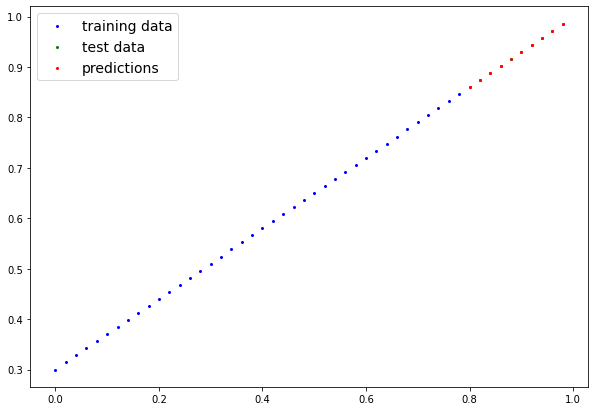

In [23]:
plot_predictions(predictions=y_preds_new);

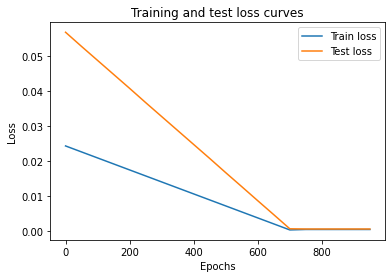

In [25]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();